In [1]:
import pandas as pd
import random
import scipy as sp
import numpy as np
import cvxpy as cvx
import mosek
import math
import matplotlib.pyplot as plt

#### Load Data

In [2]:
dfTripData = pd.read_csv("location_data.csv")
dfLoadData=pd.read_csv("use_data_2wk.csv") #365 days, 1 min increment, 142 houses 
dfGenData=pd.read_csv("annual_capfac_15MinInterpolation.csv") #representative solar day, 15 min interval
dfAsPrices=pd.read_csv('20180701_20180701_PRC_AS_DAM_v1.csv')
dfCostElectric=pd.read_csv("TOU_Rate.csv") #15 min interal 4-9 pm, I think this is tou B

#### Script Parameters

In [3]:
intNumHouseNodes = 5
intNumCommNodes = 2
intAvgNumCarsNode = 5 # goal is to have about 5 * 5 total cars
intSdNumCarsNode = 1
intProfiles = dfTripData.shape[0]

lsCostElectric =dfCostElectric.values.tolist()


# could make battery parameters a randomized instantiation
fltCarEff = 3.95 # mi/kWh
fltBatteryCap = 40. # kWh
fltChargeRate = 1.9 # kW
fltDt = 0.25 # delta T
fltHomeRate = 7 # kW
fltWorkRate = 7 # kW

#time and conversion intervals
int_minutes=int(15)
int_run_days=1 #day
int_run_hours=24 #hours
int_run_time_interval=60/int_minutes #
time_kwh=15/60  #convert kw data to kwh

#### Functions

In [4]:
#process use data to be on 15 minute interals and for specified run time, and associate with nodes

def convertLoadData(dfLoadData,run_days,int_minutes, house_nodes,commercial_nodes):
    minutes=60*24
    run_length=minutes*run_days
    dfLoadData = dfLoadData.dropna(axis=1,thresh=100) #pull only nonzeros columns, but all of them have like one so just set a threshhold
    npLoadData=dfLoadData.to_numpy() #I think iteration is faster in an np array?
    run_loads=npLoadData[0:run_length,2:]    # full run lenth extracted from dataset, 130+ loads, skip timestep/day
    nLoads=len(run_loads[0,:]) 
    resize=int(run_length/int_minutes)
    house_loads=np.zeros((resize,house_nodes))
    commercial_loads=np.zeros((resize,commercial_nodes))
    dfNodeLoads=pd.DataFrame()
    #process to 15 minutes
    i=0 #columns in the node dataframe
    for n in range(house_nodes):  
        random_select=random.randrange(0,nLoads,1)
        house_load_1min=np.sum(run_loads[:,random_select:(random_select+5)],axis=1) #5 house sum per node
        o=int(0)
        j=0
        while o < (run_length-int_minutes): 
            start=o
            end=o+int_minutes
            house_load_1min=np.array(house_load_1min,dtype="float32")
            new_interval=np.nanmean(house_load_1min[start:end])
            house_loads[j,n]=new_interval
            o+=int_minutes
            j+=1
        dfNodeLoads.insert(i,"ResNode"+str(n),house_loads[:,n],True)
        i+=1
    for k in range(commercial_nodes):  #home x10 for commercial, should replace with real commercial values! 
        random_select=random.randrange(0,nLoads,1)
        comm_load_1min=50*run_loads[:,random_select]
        o=int(0)
        j=0
        while o < (run_length-int_minutes): 
            start=o
            end=o+int_minutes
            comm_load_1min=np.array(comm_load_1min,dtype="float32")
            new_interval=np.nanmean(comm_load_1min[start:end])
            commercial_loads[j,k]=new_interval
            o+=int_minutes
            j+=1
        dfNodeLoads.insert(i,"CommNode"+str(k),commercial_loads[:,k],True) 
        i+=1
        
        maxLoads=dfNodeLoads.max()

    return dfNodeLoads, maxLoads
        
    

In [5]:
def SolarGenData(dfGenData,run_days,int_minutes, house_nodes,commercial_nodes):
    #gendata is capfac at 15 minute intervals for 24 hours 
    intervals=int(60/int_minutes*24) #intervals
    run_length=int(intervals*run_days)
    npGenData=dfGenData.to_numpy() #I think iteration is faster in an np array?
    npGenData=npGenData[:,2]
    house_gen=np.zeros((run_length,house_nodes))
    #every household must average 1 kw generation 
    house_sol_scale=1 #kw
    comm_gen=np.zeros((run_length,commercial_nodes))
    comm_sol_scale=10  #kw,assume 10x gen for solar gen at commercial
    dfNodeGens=pd.DataFrame()
    #columns in the dataframe
    i=0
    for n in range(house_nodes):  
        for d in range(run_days):
            start=0
            end=start+intervals
            house_gen[start:end,n]=np.multiply(npGenData[:],(house_sol_scale*5)) #5 house sum per node
        dfNodeGens.insert(i,"ResNode"+str(n),house_gen[:,n],True)
        i+=1
    for k in range(commercial_nodes):  #home x10 for commercial, should replace with real commercial values! 
        for d in range(run_days):
            start=0
            end=start+intervals
            comm_gen[start:end,k]=npGenData[:]*comm_sol_scale #5 house sum per node
        dfNodeGens.insert(i,"CommNode"+str(k),comm_gen[:,k],True)
        i+=1
    return dfNodeGens

In [6]:
# create residential nodes

def createCarsNodes(intNumHouseNodes, intNumCommNodes, intAvgNumCarsNode, intSdNumCarsNode, \
                    intProfiles, dfTripData):
    #initialize data frame to hold master
    dfNodesTrips = pd.DataFrame(columns=['TripId','ResNode','CommNode'])  

    for intNode in range(intNumHouseNodes):

        # find how many vehicles will be at that residential node
        intNodeNumCars = int(random.gauss(intAvgNumCarsNode,intSdNumCarsNode))
        # assign cars to that node
        lsCarIds = [] # container to hold trip id for that node
        lsCommNode = [] # container to hold where the commerical node 
        lsResNode = [] # container to hold the res node
        for intCar in range(intNodeNumCars):

            # find a car from the data frame
            ind = random.randint(0,intProfiles)
            lsCarIds.append(dfTripData['ID'].iloc[ind]) # add to car id container

            # save res node, added one because 1 initialized index was mismached with comm and load nodes
            lsResNode.append(intNode)  

            # find which commercial node that car goes to
            lsCommNode.append(random.randint(0,intNumCommNodes))

        # create data frame and add to master
        dfNode = pd.DataFrame(list(zip(lsCarIds,lsResNode,lsCommNode)), \
                              columns=['TripId','ResNode','CommNode'])

        dfNodesTrips = dfNodesTrips.append(dfNode)

    dfNodesTrips.reset_index(inplace=True, drop=True)
    
    return dfNodesTrips

    

In [7]:
def MapCarNodesTime(dfNodesTrips,dfTripData):
    #make an array that has x vehicles by 96, with location ID, sum of total for each loc
    '''
    Function to find the maximum charging rate at each time interval and whether it is
    available to charge, and the node at which it is present 
    '''

    intNumProfs = dfNodesTrips.shape[0]
    # this will hold the charging rate in kW
    arrChargeRate = np.zeros((intNumProfs, 96)) 
    # this will hold the binary of whether the vehicle can charge
    arrCanCharge = np.zeros((intNumProfs, 96))
    arrChargeLoc = np.empty((intNumProfs, 96),dtype=object)

    for ind, strId in enumerate(dfNodesTrips['TripId']):

        # get location sequence for that trip
        lsLocations = dfTripData.loc[dfTripData['ID'] == strId].iloc[0,3:-1].values

        # iterate throught the locations to get its charge rate and availability 
        for intInterval, strLoc in enumerate(lsLocations):

            if strLoc == 'H': # if at home max charge 
                arrChargeRate[ind, intInterval] = fltHomeRate
                arrCanCharge[ind,intInterval] = 1
                arrChargeLoc[ind,intInterval]='ResNode'+str(dfNodesTrips.iloc[ind].loc['ResNode'])
            elif strLoc == 'W': # working charge rate
                arrChargeRate[ind, intInterval] = fltWorkRate
                arrChargeRate[ind,intInterval] = 1
                arrChargeLoc[ind,intInterval]='CommNode'+str(dfNodesTrips.iloc[ind].loc['CommNode'])
            else: # you are moving and can't charge
                arrChargeRate[ind, intInterval] = 0
                arrChargeRate[ind, intInterval] = 0
                arrChargeLoc[ind,intInterval]=0

    return arrChargeRate, arrCanCharge, arrChargeLoc
    

In [8]:
def netLoadChargeLoc(dfNodesTrips,arrChargeLoc,dfNodeLoads,dfNodeGens):
    '''
    Find the net kw at each charge pt locations
    '''
    intNumProfs=dfNodesTrips.shape[0]
    intTime=dfNodesTrips.shape[1]
    arrNetLoad=np.zeros((intNumProfs,96))
 
    #use charge location as values to update to load value, ie charge location=column name, 
  # for i in range(intNumProfs):
  #     for j in range(96):
  #         for cell in np.nditer(arrChargeLoc):
  #         arrNetLoad[]
    
    for index, val in enumerate(arrChargeLoc):
        val=list(val)
        for i in range(intTime):
            if val[i] !=0:
                arrNetLoad[index,i]=dfNodeLoads.iloc[index].loc[val[i]]-dfNodeGens.iloc[index].loc[val[i]]
        
    return arrNetLoad

In [9]:
def findVehicleConsumption(dfNodesTrips, fltCarEff, fltDt):

    '''
    Function to find the power consumption of the vehicle at each time step
    from driving
    '''

    intNumProfs = dfNodesTrips.shape[0]
    arrConsumption = np.zeros((intNumProfs, 96))

    for ind, strId in enumerate(dfNodesTrips['TripId']):

        # find miles travelled
        fltMiles = dfTripData.loc[dfTripData['ID'] == strId,'DIST_M'].values[0]

        # get a list of locations
        lsLocations = dfTripData.loc[dfTripData['ID'] == strId].values.flatten()[3:-1].tolist()

        # so that we can find how many intervals we are away
        intAway = sum(1 if strLoc == "A" else 0 for strLoc in lsLocations)

        # miles per interval of travel and kwh per interval
        fltMiPerInt = fltMiles / intAway
        fltEnergyInt = fltMiPerInt / fltCarEff / fltDt # miles / (miles/kWh) / 0.25 hrs

        lsCarEnergy = [fltEnergyInt*-1 if strLoc == 'A' else 0 for strLoc in lsLocations ] 

        arrConsumption[ind,:] = lsCarEnergy
    
    return arrConsumption
    

In [10]:
def getSOCconstraints(dfNodesTrips, fltCarEff, fltChargeRate, fltDt):

    intNumProfs = dfNodesTrips.shape[0]
    arrSOCrequirements = np.zeros((intNumProfs, 96))

    for ind, strId in enumerate(dfNodesTrips['TripId']):

        # find miles travelled
        fltMiles = dfTripData.loc[dfTripData['ID'] == strId,'DIST_M'].values[0]

        # get a list of locations
        lsLocations = dfTripData.loc[dfTripData['ID'] == strId].values.flatten()[3:-1].tolist()

        # so that we can find how many intervals we are away
        intAway = sum(1 if strLoc == "A" else 0 for strLoc in lsLocations)

        # and then find the average miles travelled each interval
        fltAvgMileInterval = fltMiles / intAway
        
        intStart = 0 
        while intStart < 96 and 'A' in lsLocations[intStart:]:

            # Find the first first time we start moving
            intStart = intStart + lsLocations[intStart:].index('A') 

            # from there find when we arrive at a destination
            if 'W' in lsLocations[intStart:] and 'H' in lsLocations[intStart:]:
                intEnd = min(lsLocations[intStart:].index('H'), lsLocations[intStart:].index('W'))
            elif 'W' in lsLocations[intStart:]:
                intEnd = lsLocations[intStart:].index('W')
            elif 'H' in lsLocations[intStart:]:
                intEnd = lsLocations[intStart:].index('H')
            else: # we are going to assume they are driving the rest of the time??
                break
               

            # intervals driving for trip is then (intStart+intEnd +1) - intStart = intEnd =1
            # then we can find miles travelled for first trip 
            fltMilesTraveled = fltAvgMileInterval * (intEnd)
            fltKwhRequirement = fltMilesTraveled / fltCarEff # miles / (miles/kWh)
            
            # now find SOC required
            fltInitialSoc = fltKwhRequirement

            # so we need to to have the initial SOC at the interval before this time:
            arrSOCrequirements[ind,intStart-1] = fltInitialSoc
            
            # now let's back fill in SOC from there
            intNext = 2
            fltPreviousSOC = fltInitialSoc - fltChargeRate * fltDt
            while fltPreviousSOC > 0:
                
                # fill in the SOC needed in the previous time series
                arrSOCrequirements[ind, intStart - intNext] = fltPreviousSOC
                
                intNext += 1 # for next iteration go to the next previous time step
                fltPreviousSOC = fltPreviousSOC - fltChargeRate * fltDt
           

            intStart += intEnd # increment the starting point for finding the next trip
    
        
    return arrSOCrequirements


In [11]:
def getChargeRateConstraints(dfNodesTrips, dfTripData):
    '''
    Function to find the maximum charging rate at each time interval and whether it is
    available to charge. 
    '''

    intNumProfs = dfNodesTrips.shape[0]
    # this will hold the charging rate in kW
    arrChargeRate = np.zeros((intNumProfs, 96)) 
    # this will hold the binary of whether the vehicle can charge
    arrCanCharge = np.zeros((intNumProfs, 96))
    

    for ind, strId in enumerate(dfNodesTrips['TripId']):

        # get location sequence for that trip
        lsLocations = dfTripData.loc[dfTripData['ID'] == strId].iloc[0,3:-1].values

        # iterate throught the locations to get its charge rate and availability 
        for intInterval, strLoc in enumerate(lsLocations):

            if strLoc == 'H': # if at home max charge 
                arrChargeRate[ind, intInterval] = fltHomeRate
                arrCanCharge[ind,intInterval] = 1
            elif strLoc == 'W': # working charge rate
                arrChargeRate[ind, intInterval] = fltWorkRate
                arrChargeRate[ind,intInterval] = 1
            else: # you are moving and can't charge
                arrChargeRate[ind, intInterval] = 0
                arrChargeRate[ind, intInterval] = 0
    
    return arrChargeRate, arrCanCharge

In [12]:
def getInitialSoc(arrSOCconstraint): 
    '''
    Function to get an random initialization of the vehicle's SOC
    '''
    
    intNumVehicles = np.shape(arrSOCconstraint)[0]
    lsInitialSoc = np.zeros((intNumVehicles)) # holder to have the initial SOC of vehicles

    for intVehicle in range(intNumVehicles): # for each vehicle 

        fltSocStart = random.random() * fltBatteryCap
        
        # make sure that the random SOC is > the minimum SOC required
        while fltSocStart < arrSOCconstraint[intVehicle,0]:
            fltSocStart = random.random() * fltBatteryCap
        
        lsInitialSoc[intVehicle] = fltSocStart
            
    arrSOCconstraint[:,0] = lsInitialSoc
    
    return arrSOCconstraint

In [13]:
def getAsValues(dfAsPrices):
    dfAsPricesRu = dfAsPrices.loc[(dfAsPrices['ANC_REGION'] == 'AS_CAISO_EXP') \
                                    & (dfAsPrices['ANC_TYPE'] == 'RU')].sort_values('OPR_HR').reset_index()
    dfAsPricesRd = dfAsPrices.loc[(dfAsPrices['ANC_REGION'] == 'AS_CAISO_EXP') & \
                                  (dfAsPrices['ANC_TYPE'] == 'RD')].sort_values('OPR_HR').reset_index()

    lsRuValue = []
    lsRdValue = []

    for intHr in range(24):

        # get hourly $/MW price -- convert to 15 minute kWh
        fltUp = dfAsPricesRu['MW'].iloc[intHr]/1000 
        fltDown = dfAsPricesRd['MW'].iloc[intHr]/1000

        for intInterval in range(4):
            lsRuValue.append(fltUp)
            lsRdValue.append(fltDown)
    
    return lsRuValue, lsRdValue

#### Execute

In [14]:
def BatteryDegradationModel ():
    # dummy values -- MUST UPDATE
    #velvet->debugged, but wasnt sure intent on some of these, should this actually be part of a function that is called in the objective function?

    # battery constants
    fltAlphaSei = 5.75 * 10**-2
    fltBetaSei = 121
    fltKdelta1 = 1.40 * 10**5
    fltKdelta2 = -5.01 * 10**-1
    fltKdelta3= 1.23*10**5
    fltKsigma = 1.04
    fltSigmaRef = 0.5
    fltKtime = 4.14* 10**-10 # 1/s
    fltKtemp = 6.93 * 10**-2
    fltTref = 25 
    fltCost = 8500 # cost of Nissan Leaf battery replacement

    fltTemp=25
    fltDepthofDischarge=0.6
    fltStateofCharge=0.7
    fltTime=3600*int_run_hours # time in seconds


    fltStressTemp=math.exp(fltKtemp*(fltTemp-fltTref))*fltTref/fltTemp
    fltStressSOC=math.exp(fltKsigma*(fltStateofCharge-fltSigmaRef))
    fltStressTime=fltKtime*fltTime  #not clear what t is supposed to be 
    fltStressDischarge=(fltKdelta1*fltDepthofDischarge**fltKdelta2+fltKdelta3)**(-1)

    fltDegradation=(fltStressDischarge+fltStressTime)*fltStressSOC*fltStressTemp

    #varBatteryLife=1-fltAlphaSei*math.exp((-varNumberOfCycles*fltBetaSei*fltDegradation))-(1-fltAlphaSei)*math.exp((-varNumberOfCycles*fltDegradation))
    #need to double check the inputs 
        
    return fltAlphaSei,fltBetaSei,fltDegradation

In [15]:
# call functions to get Nodes Dataframe
dfNodesTrips = createCarsNodes(intNumHouseNodes, intNumCommNodes, intAvgNumCarsNode, intSdNumCarsNode, \
                    intProfiles, dfTripData)

#create df of loads for commercial & residential nodes
dfNodeLoads,maxLoads=convertLoadData(dfLoadData,int_run_days,int_minutes,intNumHouseNodes,intNumCommNodes)

#create generation for 15 min increments for each node
dfNodeGens=SolarGenData(dfGenData,int_run_days,int_minutes,intNumHouseNodes,intNumCommNodes)


# now call function to get the SOC constraints array
arrSOCconstraint = getSOCconstraints(dfNodesTrips, fltCarEff, fltChargeRate, fltDt)

# call function to get an array of maximum charging rates and map to location
arrChargeRate, arrCanCharge, arrChargeLoc=MapCarNodesTime(dfNodesTrips,dfTripData)
arrChargeRate, arrCanCharge = getChargeRateConstraints(dfNodesTrips, dfTripData)


# call function to get initial SOCs of vehicles
# replaces first column of soc constraint array
arrSOCconstraint = getInitialSoc(arrSOCconstraint)  #should this have a different name?

# call function to get power consumption of the vehicle
arrConsumption = findVehicleConsumption(dfNodesTrips, fltCarEff, fltDt)

#Get Ancillarys service cost values 
lsRuValue, lsRdValue=getAsValues(dfAsPrices)

arrNetLoad=netLoadChargeLoc(dfNodesTrips,arrChargeLoc,dfNodeLoads,dfNodeGens)

fltAlphaSei,fltBetaSei,fltDegradation=BatteryDegradationModel()




#### Define OptimizationFunctions

In [16]:
def make_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,\
                     fltDt, fltBatteryCap, arrConsumption,maxLoads):
    

    intVehicles = np.shape(arrSOCconstraint)[0]
    intTimes = np.shape(arrSOCconstraint)[1]
    
    # make variables
    varCharge = cvx.Variable((intVehicles,intTimes)) # charging rate of vehicles
    varDischarge = cvx.Variable((intVehicles,intTimes)) # discharging rate of vehicles
    varSOCs = cvx.Variable((intVehicles,intTimes)) # SOCs of the vehicles
   
    
    # initialzie constraints
    constraints = []
    
    # define the charge rate rate constraints
    constraints += [varCharge >= 0] # positively defined
    constraints += [varDischarge <= 0] # negatively defined
    constraints += [varSOCs >= 0] # can't have negative SOC
    constraints += [varSOCs <= fltBatteryCap] # can't over charge

    
    #create node summation values for each vehicle at each time step to apply node level 
    #constraints += [varCharge+arrNetLoad<=maxLoads] #still need to sum over 
    
    # define charging limits for each vehicle at each time
    for v in range(intVehicles):
      # loop through each time to model charging and SOC constraints
        for t in range(intTimes):
            
            # can only charge if present and max rate is given by array
            constraints += [varCharge[v, t] <= arrChargeRate[v,t]*arrCanCharge[v, t]]
            constraints += [-1*arrChargeRate[v,t]*arrCanCharge[v, t] <= varDischarge[v,t]]
            
            # vehicle's SOC must be greater than the minimum requirement
            constraints += [varSOCs[v,t] >= arrSOCconstraint[v,t]]
            
        
        for t in range(1,intTimes): # loop through from time 1 to end to set SOC
            
            constraints += [varSOCs[v,t]  == varSOCs[v,t-1] + varCharge[v,t]*fltDt + varDischarge[v,t]*fltDt + arrConsumption[v,t]*fltDt]
    
    return constraints, varCharge, varDischarge, varSOCs
    

In [17]:
def make_objectives(constraints, varCharge, varDischarge, varSOCs, \
                    arrCanCharge, arrChargeRate,arrSOCconstraint,fltBatteryCap,fltDt,\
                    lsCostElectric,lsRdValue,lsRuValue,fltAlphaSei,fltBetaSei,fltDegradation):
    
    
    intVehicles = np.shape(arrSOCconstraint)[0]
    intTimes = np.shape(arrSOCconstraint)[1]
    # define regulation up and down variables
    varRegUp = cvx.Variable((np.shape(arrCanCharge))) #this array is # vehiclesxtimesteps
    varRegDown = cvx.Variable((np.shape(arrCanCharge)))
#     varNumberOfCycles=cvx.Variable(intVehicles)
#     varBatteryLife=cvx.Variable(intVehicles)
#     varDegradationCost=cvx.Variable(intVehicles)

    # always positive
    constraints += [varRegUp >= 0]
    constraints += [varRegDown >= 0]
#     constraints += [varBatteryLife>= 0] #positively constrained
#     constraints += [varDegradationCost>=0] #positively constrained 
   
    for v in range(intVehicles):
#         constraints+= [varNumberOfCycles[v] == (cvx.sum(varCharge, axis=1) + \
#                                     cvx.sum(cvx.abs(varDischarge),axis=1))*fltDt/fltBatteryCap]
#         constraints+= [varBatteryLife[v] == 1 - fltAlphaSei*cvx.exp((-varNumberOfCycles[v]*fltBetaSei*fltDegradation)) \
#                                     -(1-fltAlphaSei)*cvx.exp((-varNumberOfCycles[v]*fltDegradation))]
#         constraints+= [varDegradationCost[v] == 8500*(1 - varBatteryLife[v])/0.2]
        for t in range(intTimes):
    
        #   reg down constraints
            # it is at most the charging rate if it's available
            constraints += [varRegDown[v,t] <= (arrCanCharge[v,t]*arrChargeRate[v,t] - varCharge[v,t])*lsRdValue[t]]
            # or what is left to charge batteries capacity
            constraints += [varRegDown[v,t] <= ((fltBatteryCap - varSOCs[v,t])/fltDt - varCharge[v,t])*lsRdValue[t]]
            
            # reg up constraints 
            # it is at most the charge rate if it's avalable 
            # SHOULD THIS BE - VARCHARGE OR + ???
            constraints += [varRegUp[v,t] <= (arrCanCharge[v,t]*arrChargeRate[v,t] - varDischarge[v,t])*lsRuValue[t]]
            # or what it's minimum SOC requriement is
            constraints += [varRegUp[v,t] <= ((varSOCs[v,t] - arrSOCconstraint[v,t])/fltDt - varDischarge[v,t])*lsRuValue[t]]
        
    obj_value = cvx.sum(varRegDown) + \
                cvx.sum(varRegUp) - \
                cvx.sum(lsCostElectric*cvx.sum(varCharge,axis=0)) #- \
#                cvx.sum(varDegradationCost)
    
    return constraints, obj_value, varRegUp, varRegDown

In [18]:
constraints, varCharge, varDischarge, varSOCs = make_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,\
                                                fltDt, fltBatteryCap, arrConsumption,maxLoads)

constraints, obj_value, varRegUp, varRegDown = make_objectives(constraints, varCharge, varDischarge, varSOCs,\
                    arrCanCharge, arrChargeRate,arrSOCconstraint,fltBatteryCap,fltDt, \
                    lsCostElectric,lsRdValue,lsRuValue,fltAlphaSei,fltBetaSei,fltDegradation)
    
# convex usually needs to be minimized
obj = cvx.Maximize(obj_value)
prob = cvx.Problem(obj, constraints)

prob.solve(solver=cvx.MOSEK)

132.87095177470925

Text(0.5,1,'Regulation Up Capacity')

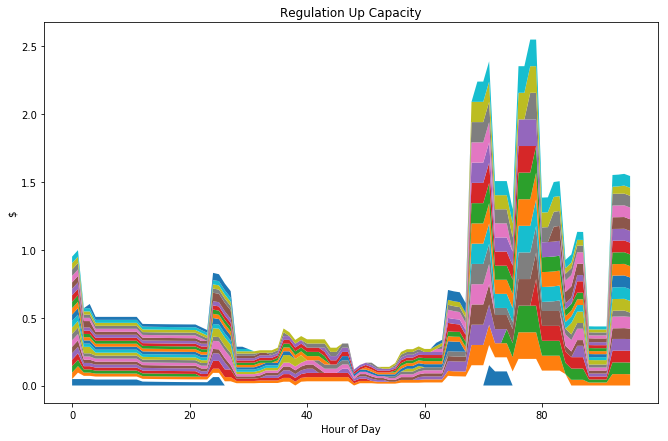

In [22]:
arrRegUp = varRegUp.value

fig, ax = plt.subplots(figsize=(11,7))
for ind in range(1,np.shape(arrRegUp)[1]):

    if ind == 1: 
        
        ax.fill_between(np.arange(96),np.zeros(96),np.array(arrRegUp[ind,:]).flatten())
    
    else: 
        
        lb = np.sum(arrRegUp[0:ind,:],axis=0)
        ub = np.sum(arrRegUp[0:ind+1,:],axis=0)
       
        ax.fill_between(np.arange(96),np.array(lb).flatten(),np.array(ub).flatten())

plt.ylabel('$')
plt.xlabel("Hour of Day")
plt.title("Regulation Up Capacity")

#### Optimize for TOU only

###### How should we calculate the time difference between when the vehicle ends charging here compared to the case where they participate in AS with V2G? 

###### At the moment, this optimization results in very little charging because the travel demand is small compared to vehicle capacity.

In [19]:
def make_tou_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,\
                     fltDt, fltBatteryCap, arrConsumption,maxLoads):
    

    intVehicles = np.shape(arrSOCconstraint)[0]
    intTimes = np.shape(arrSOCconstraint)[1]
    
    # make variables
    varCharge = cvx.Variable((intVehicles,intTimes)) # charging rate of vehicles
    # no need for discharge variable
    varSOCs = cvx.Variable((intVehicles,intTimes)) # SOCs of the vehicles
   
    
    # initialzie constraints
    constraints = []
    
    # define the charge rate rate constraints
    constraints += [varCharge >= 0] # positively defined
    constraints += [varSOCs >= 0] # can't have negative SOC
    constraints += [varSOCs <= fltBatteryCap] # can't over charge

    
    #create node summation values for each vehicle at each time step to apply node level 
    #constraints += [varCharge+arrNetLoad<=maxLoads] #still need to sum over 
    
    # define charging limits for each vehicle at each time
    for v in range(intVehicles):
      # loop through each time to model charging and SOC constraints
        for t in range(intTimes):
            
            # can only charge if present and max rate is given by array
            constraints += [varCharge[v, t] <= arrChargeRate[v,t]*arrCanCharge[v, t]]
            
            # vehicle's SOC must be greater than the minimum requirement
            constraints += [varSOCs[v,t] >= arrSOCconstraint[v,t]]
            
        
        for t in range(1,intTimes): # loop through from time 1 to end to set SOC
            
            constraints += [varSOCs[v,t]  == varSOCs[v,t-1] + varCharge[v,t]*fltDt + arrConsumption[v,t]*fltDt]
    
    return constraints, varCharge, varSOCs
    

In [20]:
def make_tou_objectives(constraints, varCharge,arrSOCconstraint,fltDt,lsCostElectric):
    
    
    intVehicles = np.shape(arrSOCconstraint)[0]
    intTimes = np.shape(arrSOCconstraint)[1]
    
    varCostToCharge = cvx.Variable(intTimes)
    
    for t in range(intTimes):
        
        constraints += [varCostToCharge[t] == cvx.sum(varCharge[:,t])*lsCostElectric[t]*fltDt]

    obj_value = cvx.sum(varCostToCharge) 
    
    return constraints, obj_value

In [21]:
constraints, varCharge, varSOCs = make_tou_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,\
                                                fltDt, fltBatteryCap, arrConsumption,maxLoads)
lsCostElectric = dfCostElectric.values
# lsCostElectric = [1 for i in range(96)]
constraints, obj_value = make_tou_objectives(constraints, varCharge,arrSOCconstraint,fltDt,lsCostElectric)

obj = cvx.Minimize(obj_value)
prob = cvx.Problem(obj, constraints)

prob.solve(solver=cvx.MOSEK)

1.1806910276770033e-10

In [29]:
num_vehicles = np.shape(arrConsumption)[0]
fltBatteryCap

40.0

/Users/michaelalevine/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


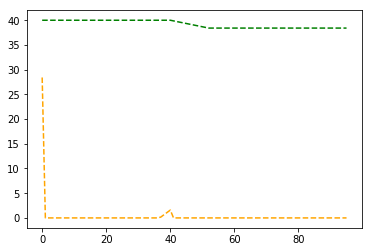

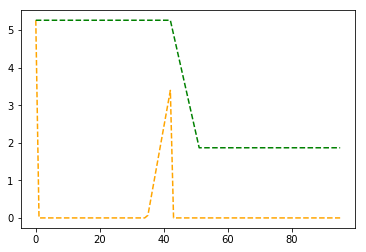

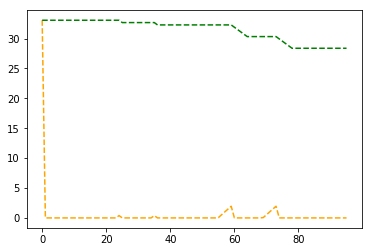

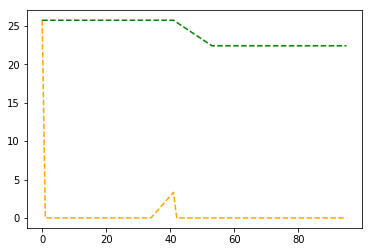

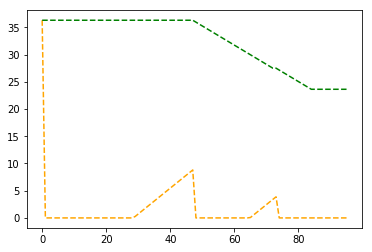

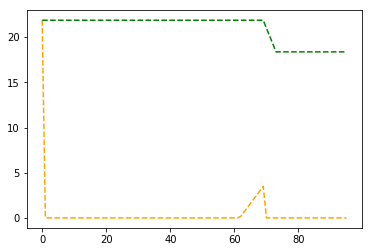

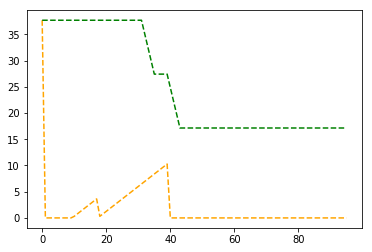

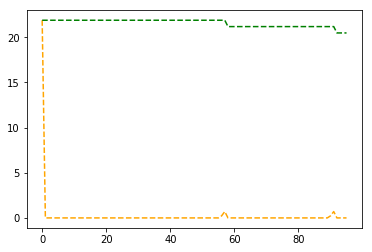

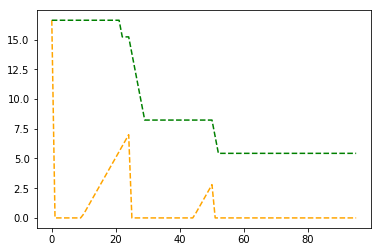

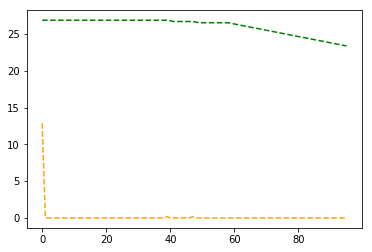

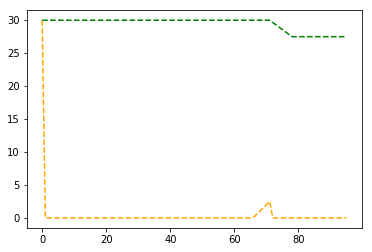

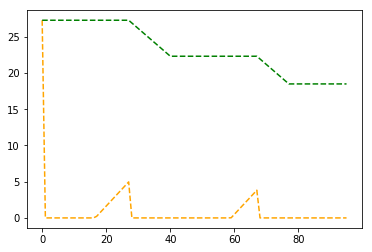

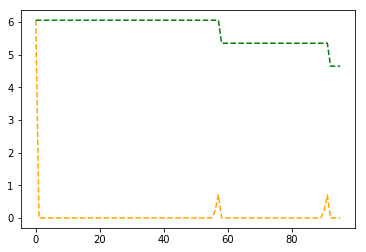

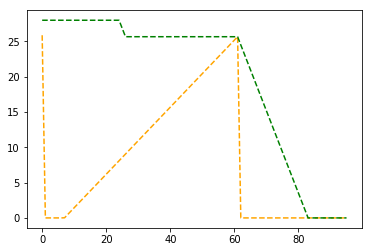

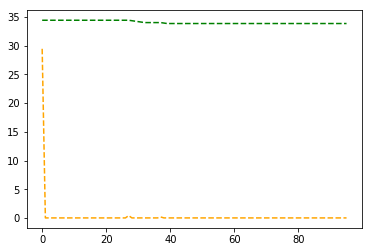

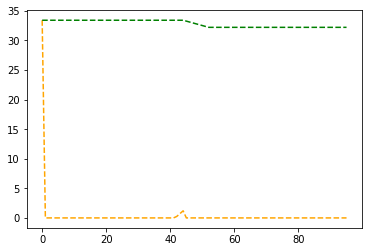

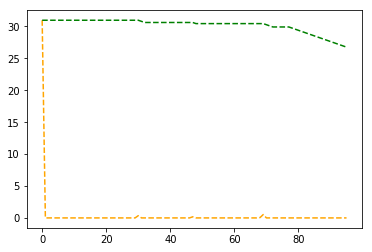

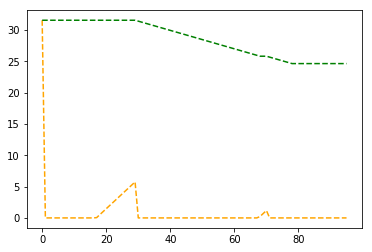

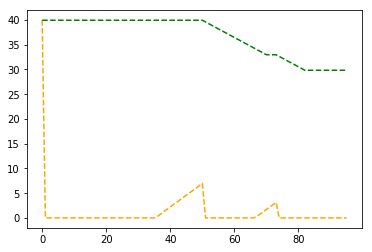

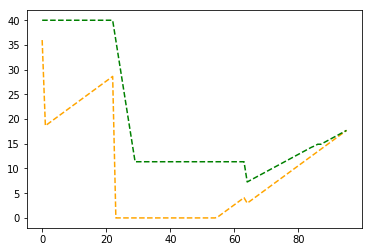

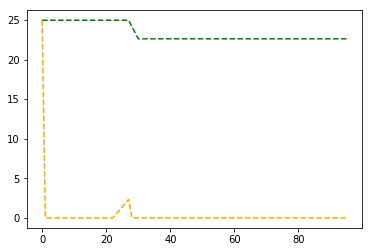

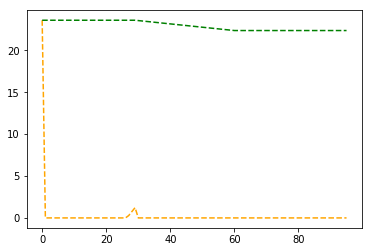

In [38]:
for v in range(num_vehicles):
    plt.figure()
#     plt.plot(np.arange(96),varCharge.value[v,:])
#     plt.plot(np.arange(96),arrConsumption[v,:])
    plt.plot(np.arange(96), arrSOCconstraint[v,:], color='orange', linestyle='--')
    plt.plot(np.arange(96), varSOCs.value[v,:], color='green',linestyle ='--')

#### Calculate the AS revenue if these were just stationary batteries

###### Are we going to compare total aggregate (not node based) AS capacity with vehcile to grid to this aggregated AS capacity?
###### Cannot directly compare node capacity since these batteries are moving? 

In [48]:
def make_battery_constraints(fltWorkRate, fltDt, fltBatteryCap, maxLoads, intVehicles, intTimes, arrSOCconstraint):
    
    
    # make variables
    varCharge = cvx.Variable((intVehicles,intTimes)) # charging rate of vehicles
    varDischarge = cvx.Variable((intVehicles, intTimes)) # discharging rate of vehicles 
    varSOCs = cvx.Variable((intVehicles,intTimes)) # SOCs of the vehicles
   
    # initialzie constraints
    constraints = []
    
    # define the charge rate rate constraints
    constraints += [varCharge >= 0]
    constraints += [varCharge <= fltWorkRate] # positively defined, max 7.7 kw
    constraints += [varDischarge <= 0]
    constraints += [varDischarge >= -1*fltWorkRate]
    constraints += [varSOCs >= 0] # can't have negative SOC
    constraints += [varSOCs <= fltBatteryCap] # can't over charge

    
    #create node summation values for each vehicle at each time step to apply node level 
    #constraints += [varCharge+arrNetLoad<=maxLoads] #still need to sum over 
    
    # SOC definition
    for v in range(intVehicles):
        
        # only specicify the inital SOC
        constraints += [varSOCs[v,0] == arrSOCconstraint[v,0]]
        
        for t in range(1,intTimes): # loop through from time 1 to end to set SOC

            constraints += [varSOCs[v,t]  == varSOCs[v,t-1] + varCharge[v,t]*fltDt + varDischarge[v,t]*fltDt]

    return constraints, varCharge, varDischarge, varSOCs
    

In [62]:
def make_battery_objectives(constraints, varCharge, varDischarge, varSOCs, intVehicles, intTimes, \
                    fltBatteryCap,fltDt,lsCostElectric,lsRdValue,lsRuValue,
                    fltAlphaSei,fltBetaSei,fltDegradation):
    
    
    # define regulation up and down variables
    varRegUp = cvx.Variable((intVehicles, intTimes)) #this array is # vehiclesxtimesteps
    varRegDown = cvx.Variable((intVehicles, intTimes))
#     varNumberOfCycles=cvx.Variable(intVehicles)
#     varBatteryLife=cvx.Variable(intVehicles)
#     varDegradationCost=cvx.Variable(intVehicles)

#     # always positive
    constraints += [varRegUp >= 0]
    constraints += [varRegDown >= 0]
#     constraints += [varBatteryLife>= 0] #positively constrained
#     constraints += [varDegradationCost>=0] #positively constrained 
   
    for v in range(intVehicles):
#         constraints+= [varNumberOfCycles[v] == (cvx.sum(varCharge, axis=1) + \
#                                     cvx.sum(cvx.abs(varDischarge),axis=1))*fltDt/fltBatteryCap]
#         constraints+= [varBatteryLife[v] == 1 - fltAlphaSei*cvx.exp((-varNumberOfCycles[v]*fltBetaSei*fltDegradation)) \
#                                     -(1-fltAlphaSei)*cvx.exp((-varNumberOfCycles[v]*fltDegradation))]
#         constraints+= [varDegradationCost[v] == 8500*(1 - varBatteryLife[v])/0.2]
        for t in range(intTimes):
    
            # reg down constraints
            # it is at most the charging rate if it's available
            constraints += [varRegDown[v,t] <= (fltWorkRate - varCharge[v,t])*lsRdValue[t]]
            # or what is left to charge batteries capacity
            constraints += [varRegDown[v,t] <= ((fltBatteryCap - varSOCs[v,t])/fltDt - varCharge[v,t])*lsRdValue[t]]
            
            # reg up constraints 
            # it is at most the charge rate if it's avalable 
            # SHOULD THIS BE - VARCHARGE OR + ???
            constraints += [varRegUp[v,t] <= (fltWorkRate + varDischarge[v,t])*lsRuValue[t]]
            # or what it's minimum SOC requriement is
            constraints += [varRegUp[v,t] <= (varSOCs[v,t]/fltDt + varDischarge[v,t])*lsRuValue[t]]
            
        
    obj_value = cvx.sum(varRegDown) + \
                cvx.sum(varRegUp) #- \
#                 cvx.sum(lsCostElectric*cvx.sum(varCharge,axis=0)) #- \
#                cvx.sum(varDegradationCost)
    
    return constraints, obj_value, varRegUp, varRegDown

In [63]:
intVehicles = np.shape(arrChargeRate)[0]
intTimes = np.shape(arrChargeRate)[1]

constraints, varCharge, varDischarge, varSOCs = make_battery_constraints(fltWorkRate, \
                                        fltDt, fltBatteryCap, maxLoads, intVehicles, intTimes, arrSOCconstraint)
constraints, obj_value, varRegUp, varRegDown = make_battery_objectives(constraints, varCharge, varDischarge, \
                    varSOCs, intVehicles, intTimes, \
                    fltBatteryCap,fltDt,lsCostElectric,lsRdValue,lsRuValue, \
                    fltAlphaSei,fltBetaSei,fltDegradation)

obj = cvx.Maximize(obj_value)
prob = cvx.Problem(obj, constraints)


arrRegUp = varRegUp.value
arrRegDown = varRegDown.value
print('Done!')

Done!


In [64]:
varCharge.value

In [65]:
varRegDown.value

In [60]:
varRegUp.value

In [41]:
np.min(lsRdValue)

0.00055

In [56]:
intVehicles

22